# UZOP - Projekt (2024/2025.)

## Autori:
- Lana Bartolović
- Mia Krstičević
- Dunja Petrović
- Lucija Runjić


U ovom dijelu projekta cilj je u grupama napraviti replikaciju i poboljšanje rezultata članka: https://pmc.ncbi.nlm.nih.gov/articles/PMC8927715/.

## Priprema podataka

Na početku je potrebno učitati sve potrebne biblioteke koje će se koristiti u daljnjoj analizi podatkovnog skupa te je zatim potrebno učitati podatkovni skup u varijablu.

In [1]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [2]:
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,precision_score,recall_score, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
alzheimer_original = pd.read_csv('/oasis_longitudinal.csv')

### Čišćenje podatkovnog skupa

Podatkovni skup treba očistiti kako bi se analiza radila samo nad relevantnim podatcima. Obzirom da se u skupu neki pacijenti pojavljuju više puta (zbog više posjeta liječniku), treba preurediti podatke na način da se za svakog pacijenta uzima samo njegov prvi posjet (`Visit`) kako vizualizacija i statistika značajki ne bi bila pristrana prema pacijentima s više posjeta. Kako se gleda samo prvi posjet, značajka `MR Delay` onda više ne daje nikakvu korisnu informaciju te je iz tog razloga uklonjena.
Također, značajka `CDR` uklonjena je zbog visoke korelacije s izlaznom varijablom, što bi moglo negativno utjecati na kvalitetu i točnost modela.

In [4]:
alzheimer_original = alzheimer_original[alzheimer_original['Visit'] == 1]
alzheimer_original = alzheimer_original.drop(['MR Delay'], axis=1)
alzheimer_original = alzheimer_original.drop(['CDR'], axis=1)
print(alzheimer_original)

    Subject ID         MRI ID        Group  Visit M/F Hand  Age  EDUC  SES  \
0    OAS2_0001  OAS2_0001_MR1  Nondemented      1   M    R   87    14  2.0   
2    OAS2_0002  OAS2_0002_MR1     Demented      1   M    R   75    12  NaN   
5    OAS2_0004  OAS2_0004_MR1  Nondemented      1   F    R   88    18  3.0   
7    OAS2_0005  OAS2_0005_MR1  Nondemented      1   M    R   80    12  4.0   
10   OAS2_0007  OAS2_0007_MR1     Demented      1   M    R   71    16  NaN   
..         ...            ...          ...    ...  ..  ...  ...   ...  ...   
359  OAS2_0182  OAS2_0182_MR1     Demented      1   M    R   73    12  NaN   
361  OAS2_0183  OAS2_0183_MR1  Nondemented      1   F    R   66    13  2.0   
365  OAS2_0184  OAS2_0184_MR1     Demented      1   F    R   72    16  3.0   
367  OAS2_0185  OAS2_0185_MR1     Demented      1   M    R   80    16  1.0   
370  OAS2_0186  OAS2_0186_MR1  Nondemented      1   F    R   61    13  2.0   

     MMSE  eTIV   nWBV    ASF  
0    27.0  1987  0.696  0.883  

Potrebno je ukloniti značajke koje sadrže monotone ili konstantne vrijednosti.

In [5]:
# značajke s konstantnim vrijednostima
constant_columns = alzheimer_original.columns[alzheimer_original.nunique() == 1]
print("Značajke s konstantnim vrijednostima:")
print(list(constant_columns))
alzheimer_original.drop(constant_columns, axis=1, inplace=True)

# značajke s monotonim vrijednostima
ascending_columns = alzheimer_original.columns[alzheimer_original.apply(lambda x: x.is_monotonic_increasing)]
descending_columns = alzheimer_original.columns[alzheimer_original.apply(lambda x: x.is_monotonic_decreasing)]
mono_columns = ascending_columns.append(descending_columns)
print("Značajke s monotonim vrijednostima:")
print(list(mono_columns))
alzheimer_original.drop(mono_columns, axis=1, inplace=True)

Značajke s konstantnim vrijednostima:
['Visit', 'Hand']
Značajke s monotonim vrijednostima:
['Subject ID', 'MRI ID']


Svim ispitanicima je dominantna desna ruka, stoga je ta značajka uklonjena (`Hand`). Osim nje, uklonjena je i značajka `Visited` koja je sada isto konstantna značajka ozbirom da je na početku podatkovni skup filtriran na način da se gleda samo prvi posjet.
Također, uklonjene su značajke `Subject ID` i `MRI ID` koje samo označavaju identifikacijske brojeve ispitanika i MRI snimaka a ne donose nikakvu dodatnu informaciju korisnu za analizu.

Zatim je potrebno provjeriti postoje li značajke s nedostajućim vrijednostima i ako postoje, na određen način riješiti taj problem ovisno o situaciji.

In [6]:
alzheimer_replica = alzheimer_original.copy()
missing_values = alzheimer_original.isnull().sum()

# Ispis značajki i broja nedostajućih vrijednosti
for column, value in missing_values.items():
    if value > 0:
        print(f"{column}: {value}")

# SES - izračun postotka nedostajućih vrijednosti
missing_value_percentage = (missing_values['SES'] / len(alzheimer_original)) * 100
print(f"Postotak nedostajućih vrijednosti za SES: {missing_value_percentage:.2f}%")

# Zamjena nedostajućih vrijednosti medianom
for column in alzheimer_original.columns:
    if alzheimer_original[column].isnull().sum() > 0:
        median_value = alzheimer_original[column].median()
        alzheimer_original[column].fillna(median_value, inplace=True)
        print(f"Nedostajuće vrijednosti u '{column}' zamijenjene medianom: {median_value}")

# Ponovna provjera nedostajućih vrijednosti
if alzheimer_original.isnull().sum().any():
    print("Nedostajuće vrijednosti i dalje postoje")
else:
    print("Nedostajuće vrijednosti više ne postoje")

SES: 8
Postotak nedostajućih vrijednosti za SES: 5.33%
Nedostajuće vrijednosti u 'SES' zamijenjene medianom: 2.0
Nedostajuće vrijednosti više ne postoje


Nedostajuće vrijednosti u stupcu `SES` zamijenjene su medianom kako bi se očuvala konzistentnost i izbjeglo brisanje podataka.

### Transformacija podataka

Sada je potrebno pripremiti podatke za modeliranje kroz skaliranje numeričkih značajki i enkodiranje kategoričkih značajki:

**Numeričke značajke:**  
Numeričke značajke su normalizirane koristeći `StandardScaler` koji značajke standardizira oko srednje vrijednosti 0.

**Kategoričke značajke:**  

Značajka **`Group`** sadrži tri kategorije:  `Demented`, `Nondemented` i `Converted`. Budući da se u trenutnoj analizi uzima u obzir samo prvi posjet svake osobe, grupa `Converted` tretira se kao `Nondemented` jer su na prvom posjetu sigurno bili `Nondemented` ako pripadaju grupi `Converted`.

Tako su i značajka `Group` i načajka `M/F` binarne značajke te se enkodiraju pomoću tehnike `label enkodiranja` kako bi se izbjegla multikolinearnost.

In [7]:
def transform_data(dataset):
  categorical_columns = dataset.select_dtypes(include=[np.object_]).columns
  numerical_columns = dataset.select_dtypes(include=[np.number]).columns

  dataset['M/F'] = dataset['M/F'].astype('category')
  mf_values = dict(enumerate(dataset['M/F'].cat.categories))
  dataset['M/F_M'] = dataset['M/F'].cat.codes
  dataset.drop(['M/F'], axis=1, inplace=True)

  print(mf_values)

  dataset.loc[dataset['Group'] == 'Converted', 'Group'] = 'Nondemented'
  dataset['Group'] = dataset['Group'].astype('category')
  mf_values = dict(enumerate(dataset['Group'].cat.categories))
  dataset['Group_Nondemented'] = dataset['Group'].cat.codes
  dataset.drop(['Group'], axis=1, inplace=True)

  print(mf_values)

  scaler = StandardScaler()
  dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

  return dataset

In [8]:
alzheimer_original = transform_data(alzheimer_original)
print(alzheimer_original.head(5))
alzheimer_correlation = alzheimer_original.copy(deep=True)

{0: 'F', 1: 'M'}
{0: 'Demented', 1: 'Nondemented'}
         Age      EDUC       SES      MMSE      eTIV      nWBV       ASF  \
0   1.536301 -0.186147 -0.424437 -0.189281  2.944121 -1.102837 -2.353155   
2  -0.059395 -0.884199 -0.424437 -1.541291  1.169285 -0.002018 -1.166874   
5   1.669276  1.209957  0.485071  0.148721 -1.490096 -0.717550  1.729691   
7   0.605478 -0.884199  1.394580  0.148721  1.232467 -0.662509 -1.217819   
10 -0.591294  0.511905 -0.424437  0.148721 -0.674476  0.328227  0.630743   

    M/F_M  Group_Nondemented  
0       1                  1  
2       1                  0  
5       0                  1  
7       1                  1  
10      1                  0  


## Replikacija rezultata

U ovom dijelu potrebno je napraviti replikaciju metoda korištenih u gore navedenom članku. U članku se koriste sljedeći modeli strojnog učenja za predikciju izlazne varijable: `Decision tree classifier`, `Random forest classifier`, `Support vector machine`, `XGBoost` i `Voting classifier`. U svim modelima su train i test skup podjeljeni u omjeru 80%/20%.

Prvo se podatkovni skup dijeli na značajke i izlaznu varijablu (`Group_Nondemented`).

In [9]:
y = alzheimer_original['Group_Nondemented']
X = alzheimer_original.drop(['Group_Nondemented'], axis=1)
seed = 60
models = ['Decision tree classifier', 'Random forest classifier', 'Support vector machine', 'XGBoost', 'Hard voting', 'Soft voting']

In [10]:
def calculate_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return accuracy, precision, recall, f1

In [11]:
def try_models(X_train, X_test, y_train, y_test):
  accuracies = []
  precisions = []
  recalls = []
  f1_scores = []
  predictions = []

  #Decision tree
  model_dt = DecisionTreeClassifier()
  model_dt.fit(X_train, y_train)
  y_pred_dt = model_dt.predict(X_test)

  accuracy_dt, precision_dt, recall_dt, f1_dt = calculate_metrics(y_test, y_pred_dt)

  # Random Forest
  model_rf = RandomForestClassifier()
  model_rf.fit(X_train, y_train)
  y_pred_rf = model_rf.predict(X_test)

  accuracy_rf, precision_rf, recall_rf, f1_rf = calculate_metrics(y_test, y_pred_rf)

  # SVM
  model_svm = SVC(probability=True)
  model_svm.fit(X_train, y_train)
  y_pred_svm = model_svm.predict(X_test)

  accuracy_svm, precision_svm, recall_svm, f1_svm = calculate_metrics(y_test, y_pred_svm)

  # XGB
  model_xgb = XGBClassifier(use_label_encoder = False)
  model_xgb.fit(X_train, y_train)
  y_pred_xgb = model_xgb.predict(X_test)

  accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = calculate_metrics(y_test, y_pred_xgb)

  # Hard voting
  model_voting_hard = VotingClassifier(
      estimators=[
          ("Decision tree", model_dt),
          ("Random forest", model_rf),
          ("SVM", model_svm),
          ("XGBoost", model_xgb)
      ],
      voting='hard'
  )

  model_voting_hard.fit(X_train, y_train)
  y_pred_voting_hard = model_voting_hard.predict(X_test)

  accuracy_voting_hard, precision_voting_hard, recall_voting_hard, f1_voting_hard = calculate_metrics(y_test, y_pred_voting_hard)

  # Soft voting
  model_voting_soft = VotingClassifier(
      estimators=[
          ("Decision tree", model_dt),
          ("Random forest", model_rf),
          ("SVM", model_svm),
          ("XGBoost", model_xgb)
      ],
      voting='soft'
  )

  model_voting_soft.fit(X_train, y_train)
  y_pred_voting_soft = model_voting_soft.predict(X_test)

  accuracy_voting_soft, precision_voting_soft, recall_voting_soft, f1_voting_soft = calculate_metrics(y_test, y_pred_voting_soft)

  accuracies = [accuracy_dt, accuracy_rf, accuracy_svm, accuracy_xgb, accuracy_voting_hard, accuracy_voting_soft]
  precisions = [precision_dt, precision_rf, precision_svm, precision_xgb, precision_voting_hard, precision_voting_hard]
  recalls = [recall_dt, recall_rf, recall_svm, recall_xgb, recall_voting_hard, recall_voting_soft]
  f1_scores = [f1_dt, f1_rf, f1_svm, f1_xgb, f1_voting_hard, f1_voting_soft]
  predictions = [y_pred_dt, y_pred_rf, y_pred_svm, y_pred_xgb, y_pred_voting_hard, y_pred_voting_soft]

  return accuracies, precisions, recalls, f1_scores, predictions

In [12]:
results_article = [
    [models[0], 80.46, 0.80, 0.79, 0.78],
    [models[1], 86.92, 0.85, 0.81, 0.80],
    [models[2], 81.67, 0.77, 0.70, 0.79],
    [models[3], 85.92, 0.85, 0.83, 0.85],
    [models[4], 85.12, 0.83, 0.83, 0.85],
    ['Voting classifier', 85.12, 0.83, 0.83, 0.85]
]

df_results_article = pd.DataFrame(results_article, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

df_results_article['Accuracy'] = (df_results_article['Accuracy']).astype(str) + '%'
df_results_article['Precision'] = (df_results_article['Precision']).round(2)
df_results_article['Recall'] = (df_results_article['Recall']).round(2)
df_results_article['F1-score'] = (df_results_article['F1-score']).round(2)

In [13]:
def print_results_article(df_results_article):
  print(tabulate(df_results_article, headers='keys', tablefmt='pretty', showindex=False))

def print_results(accuracies, precisions, recalls, f1_scores, models):

    results = [
        [models[i], accuracies[i], precisions[i], recalls[i], f1_scores[i]]
        for i in range(len(models))
    ]

    df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

    df_results['Accuracy'] = ((df_results['Accuracy'] * 100).round(2)).astype(str) + '%'
    df_results['Precision'] = df_results['Precision'].round(2)
    df_results['Recall'] = df_results['Recall'].round(2)
    df_results['F1-score'] = df_results['F1-score'].round(2)

    print(tabulate(df_results, headers='keys', tablefmt='pretty', showindex=False))


In [14]:
def draw_confusion_matrices(y_test, y_preds):
  plt.figure(figsize=(15, 10))

  tmp = 1
  for model, y_pred in zip(models, y_preds):
    cm_matrix = confusion_matrix(y_test, y_pred)
    plt.subplot(3, 3, tmp)
    ax = sns.heatmap(cm_matrix, annot=True, cmap='Purples', xticklabels=['Demented', 'Nondemented'], yticklabels=['Demented', 'Nondemented'])
    ax.set_title(model)
    tmp += 1

  plt.tight_layout()
  plt.show()

In [15]:
def draw_bar_charts(accuracies, precisions, recalls, f1_scores):
  plt.figure(figsize=(15, 10))

  metrics = [accuracies, precisions, recalls, f1_scores]
  metric_names = ["Accuracy", "Precision", "Recall", "F1-Score"]

  tmp = 1
  for i in range(len(metrics)):
    plt.subplot(2, 2, tmp)
    plt.bar(models, metrics[i])
    plt.xlabel("ML Algorithm")
    plt.ylabel(metric_names[i])
    plt.xticks(rotation=45)
    tmp += 1

  plt.subplots_adjust(wspace=0.2, hspace=0.6)
  plt.show()

In [16]:
def draw_comparison_bar_charts(accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig,
                               accuracies_drop, precisions_drop, recalls_drop, f1_scores_drop, models):
    plt.figure(figsize=(15, 10))

    metrics_orig = [accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig]
    metrics_drop = [accuracies_drop, precisions_drop, recalls_drop, f1_scores_drop]
    metric_names = ["Accuracy", "Precision", "Recall", "F1-Score"]

    tmp = 1
    for i in range(len(metrics_orig)):
        plt.subplot(2, 2, tmp)

        bar_width = 0.35
        index = np.arange(len(models))

        plt.bar(index, metrics_orig[i], bar_width, label='Original', alpha=0.7)
        plt.bar(index + bar_width, metrics_drop[i], bar_width, label='New', alpha=0.7)

        plt.xlabel("ML Algorithm")
        plt.ylabel(metric_names[i])
        plt.xticks(index + bar_width / 2, models, rotation=45)
        plt.legend()

        tmp += 1

    plt.subplots_adjust(wspace=0.4, hspace=1.1)
    plt.show()

In [17]:
def draw_auc_curves(y_test, y_probs, models):
    plt.figure(figsize=(12, 8))

    for i, (model, y_prob) in enumerate(zip(models, y_probs)):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{model} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC/ROC Curves")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig, predictions_orig = try_models(X_train, X_test, y_train, y_test)

In [19]:
print("Rezultati članka:")
print_results_article(df_results_article)
print("\n")
print("Naši rezultati:")
print_results(accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig, models)

Rezultati članka:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifier |  80.46%  |    0.8    |  0.79  |   0.78   |
| Random forest classifier |  86.92%  |   0.85    |  0.81  |   0.8    |
|  Support vector machine  |  81.67%  |   0.77    |  0.7   |   0.79   |
|         XGBoost          |  85.92%  |   0.85    |  0.83  |   0.85   |
|       Hard voting        |  85.12%  |   0.83    |  0.83  |   0.85   |
|    Voting classifier     |  85.12%  |   0.83    |  0.83  |   0.85   |
+--------------------------+----------+-----------+--------+----------+


Naši rezultati:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifier |

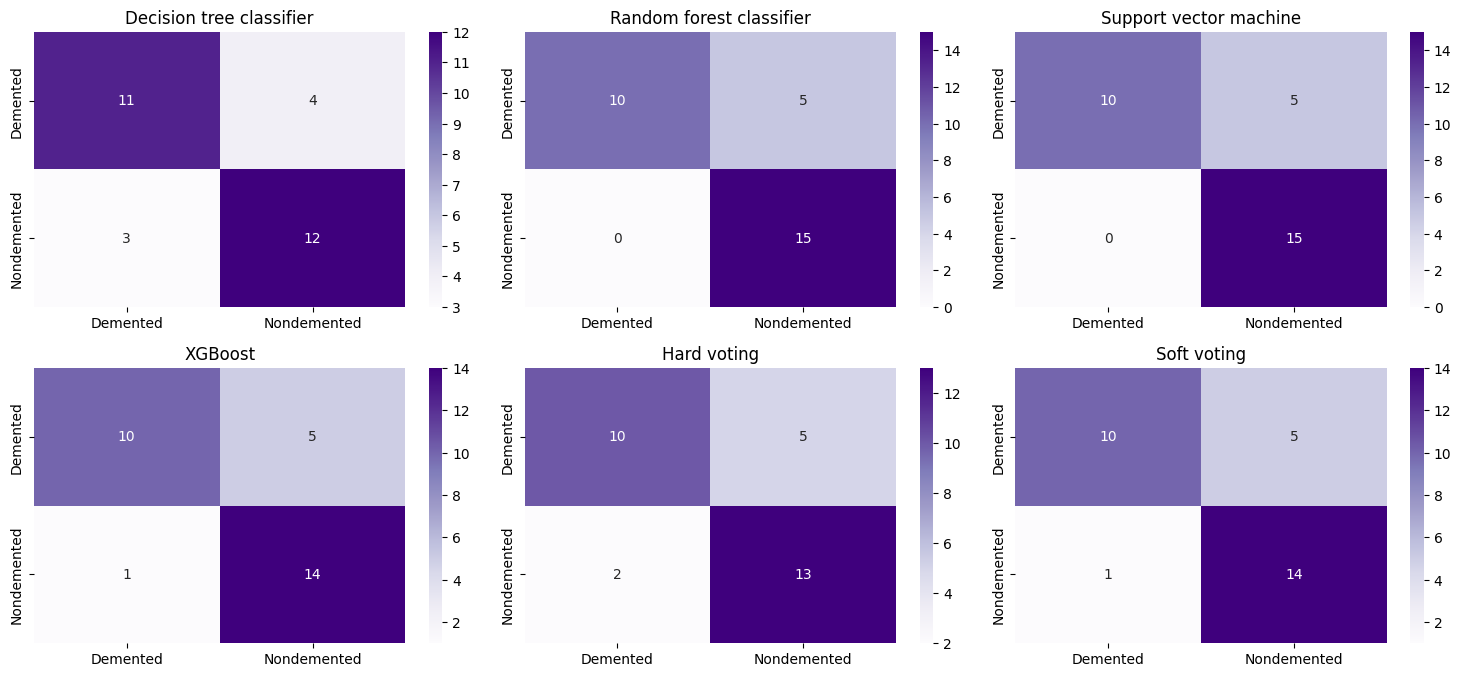

In [20]:
y_preds = [predictions_orig[0], predictions_orig[1], predictions_orig[2], predictions_orig[3], predictions_orig[4], predictions_orig[5]]
draw_confusion_matrices(y_test, y_preds)

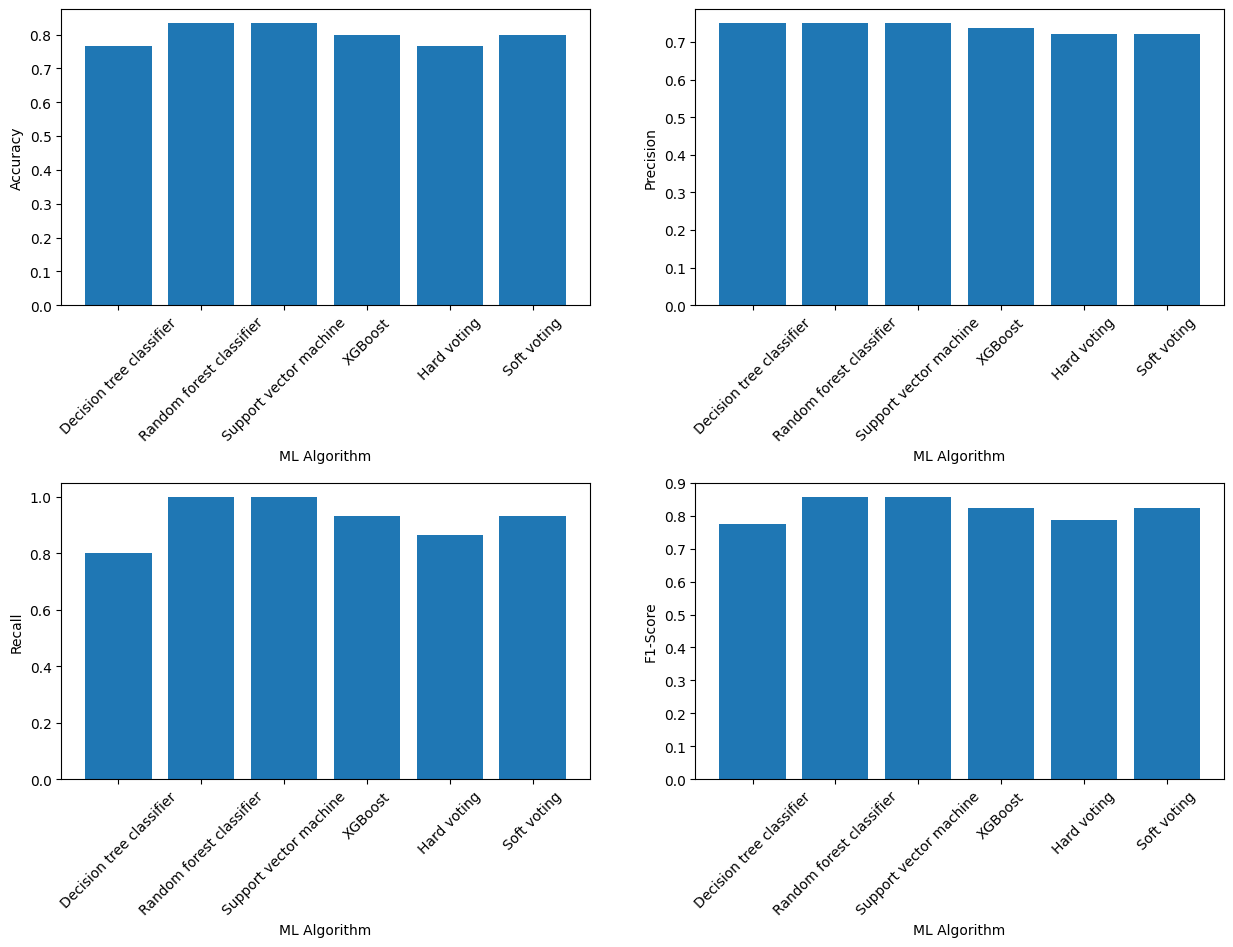

In [21]:
draw_bar_charts(accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig)

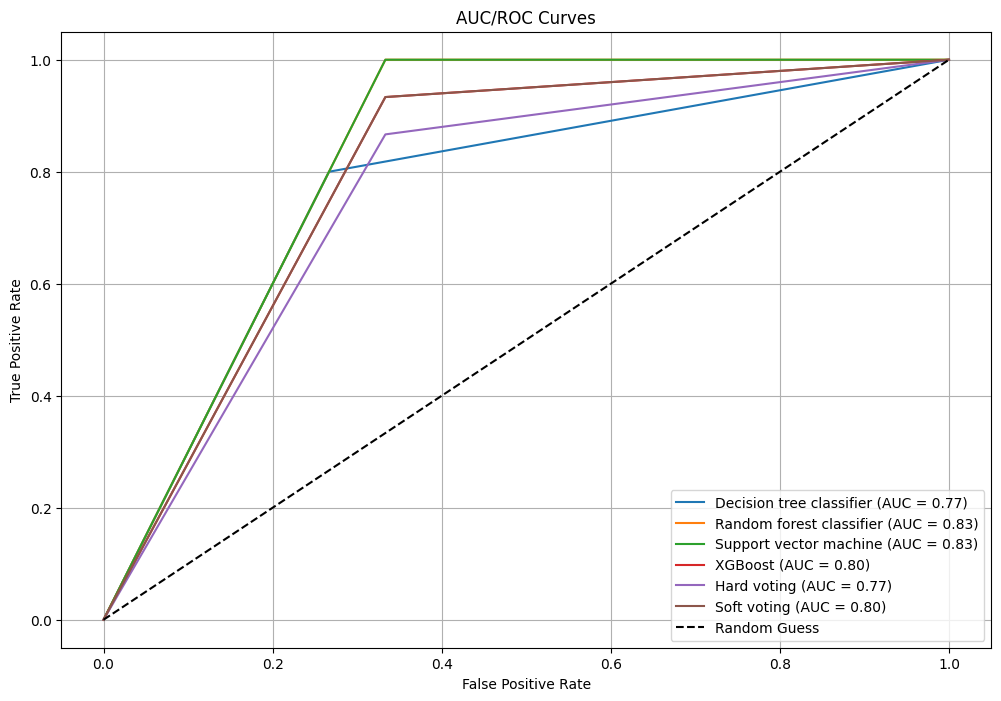

In [22]:
draw_auc_curves(y_test, predictions_orig, models)

## Poboljšanje rezultata

U ovom dijelu cilj nam je unaprijediti replicirane rezultate članka koristeći nekoliko različitih pristupa.

Prvo smo primijenili k-fold unakrsnu validaciju kako bismo smanjili utjecaj slučajnog odabira seed-a na rezultate.

Zatim smo testirali različite omjere između skupa za treniranje i testiranje.

Umjesto zamjene nedostajućih vrijednosti medijanom, kao što je učinjeno u članku, odlučili smo ukloniti redove s nedostajućim vrijednostima. Budući da je broj takvih redova bio vrlo malen, njihovim uklanjanjem nije značajno narušena kvaliteta podatkovnog skupa.

Nakon toga, nastojali smo povećati broj podataka tako da smo konvertirane primjere, tj. pacijente koji su prvotno bili nedementni, a kasnije postali dementni, uključili dvaput. Prvi posjet označili smo kao "Nondemented", jer su tada sigurno bili nedementni, dok smo posljednji posjet označili kao "Demented", jer su tada sigurno bili dementni.

Na kraju smo pokušali poboljšati performanse modela uklanjanjem određenih značajki i tako biranjem optimalnog podskupa značajki.

### K-fold unakrsna validacija

`KFold unakrsna validacija` je metoda za procjenu modela u kojoj se podaci dijele u `k` dijelova (foldova), a svaki fold se koristi kao testni skup podataka jednom, dok se preostali `k-1` dijelova koristi kao trenirajući skup.

In [23]:
def try_models_with_kfold(X, y, k=5):

    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    accuracies, precisions, recalls, f1_scores, predictions = [], [], [], [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Inicijalizacija modela
        model_dt = DecisionTreeClassifier()
        model_rf = RandomForestClassifier()
        model_svm = SVC(probability=True)
        model_xgb = XGBClassifier()

        # Trening i evaluacija modela
        models = {
            'Decision Tree': model_dt,
            'Random Forest': model_rf,
            'SVM': model_svm,
            'XGB': model_xgb,
        }

        # Hard Voting
        model_voting_hard = VotingClassifier(
            estimators=[
                ("Decision tree", model_dt),
                ("Random forest", model_rf),
                ("SVM", model_svm)
            ],
            voting='hard'
        )

        # Soft Voting
        model_voting_soft = VotingClassifier(
            estimators=[
                ("Decision tree", model_dt),
                ("Random forest", model_rf),
                ("SVM", model_svm)
            ],
            voting='soft'
        )

        # Evaluacija svih modela
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            predictions.append(y_pred)

        # Evaluacija Hard i Soft Voting modela
        for model_voting in [model_voting_hard, model_voting_soft]:
            model_voting.fit(X_train, y_train)
            y_pred_voting = model_voting.predict(X_test)
            accuracy_voting, precision_voting, recall_voting, f1_voting = calculate_metrics(y_test, y_pred_voting)
            accuracies.append(accuracy_voting)
            precisions.append(precision_voting)
            recalls.append(recall_voting)
            f1_scores.append(f1_voting)
            predictions.append(y_pred_voting)

    return accuracies, precisions, recalls, f1_scores, predictions

In [24]:
X_kf = X.copy()
y_kf = y.copy()
X_kf = X_kf.to_numpy()
y_kf = y_kf.to_numpy()

accuracies_kf, precisions_kf, recalls_kf, f1_scores_kf, predictions_kf = try_models_with_kfold(X_kf, y_kf)

In [25]:
print("Rezultati članka:")
print_results_article(df_results_article)
print("\n")
print("Naši originalni rezultati:")
print_results(accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig, models)
print("\n")
print("Naši rezultati k-fold unakrsne validacije:")
print_results(accuracies_kf, precisions_kf, recalls_kf, f1_scores_kf, models)

Rezultati članka:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifier |  80.46%  |    0.8    |  0.79  |   0.78   |
| Random forest classifier |  86.92%  |   0.85    |  0.81  |   0.8    |
|  Support vector machine  |  81.67%  |   0.77    |  0.7   |   0.79   |
|         XGBoost          |  85.92%  |   0.85    |  0.83  |   0.85   |
|       Hard voting        |  85.12%  |   0.83    |  0.83  |   0.85   |
|    Voting classifier     |  85.12%  |   0.83    |  0.83  |   0.85   |
+--------------------------+----------+-----------+--------+----------+


Naši originalni rezultati:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree c

K-fold unakrsna validacija, ovisno o odabranom seed-u, ponekad daje slične ili čak nešto lošije rezultate u usporedbi s pristupom bez nje. No njena primjena ipak osigurava stabilnije rezultate pri promjeni seed-a. To je i očekivano, budući da je upravo to glavna svrha k-fold metode.

### Različiti omjeri train/test

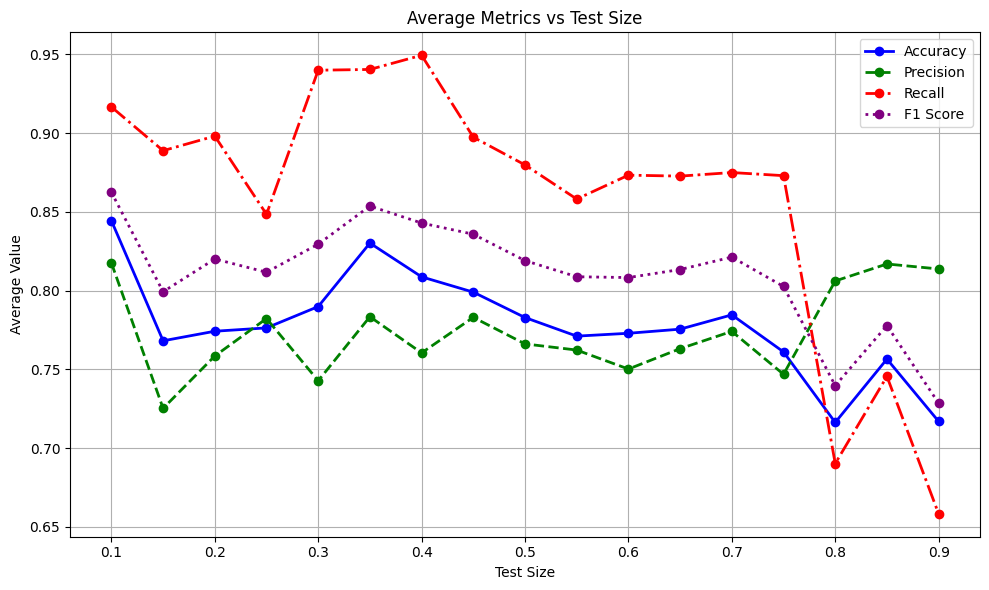

In [26]:
test_sizes = np.arange(0.1, 0.925, 0.05)
results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    # treniranje modela
    accuracies, precisions, recalls, f1_scores, predictions = try_models(X_train, X_test, y_train, y_test)
    results.append((test_size, accuracies, precisions, recalls, f1_scores))

avg_accuracies = []
avg_precisions = []
avg_recalls = []
avg_f1_scores = []

for test_size, accuracies, precisions, recalls, f1_scores in results:
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1_score = sum(f1_scores) / len(f1_scores)

    avg_accuracies.append(avg_accuracy)
    avg_precisions.append(avg_precision)
    avg_recalls.append(avg_recall)
    avg_f1_scores.append(avg_f1_score)

plt.figure(figsize=(10, 6))

plt.plot(test_sizes, avg_accuracies, marker='o', color='b', label='Accuracy', linestyle='-', linewidth=2)
plt.plot(test_sizes, avg_precisions, marker='o', color='g', label='Precision', linestyle='--', linewidth=2)
plt.plot(test_sizes, avg_recalls, marker='o', color='r', label='Recall', linestyle='-.', linewidth=2)
plt.plot(test_sizes, avg_f1_scores, marker='o', color='purple', label='F1 Score', linestyle=':', linewidth=2)

plt.title('Average Metrics vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Nakon isprobavanja i analize grafova za različite seed-ove, čini se da bi optimalna veličina testnog skupa mogla 0.3. Stoga je u nastavku provedena prvotna replikacija rezultata, ali s promijenjenim omjerom podjela između skupa za trening i test.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
accuracies_new, precisions_new, recalls_new, f1_scores_new, predictions_new = try_models(X_train, X_test, y_train, y_test)

In [28]:
print("Rezultati članka:")
print_results_article(df_results_article)
print("\n")
print("Naši originalni rezultati:")
print_results(accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig, models)
print("\n")
print("Naši rezultati sa veličinom test skupa 0.3:")
print_results(accuracies_new, precisions_new, recalls_new, f1_scores_new, models)

Rezultati članka:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifier |  80.46%  |    0.8    |  0.79  |   0.78   |
| Random forest classifier |  86.92%  |   0.85    |  0.81  |   0.8    |
|  Support vector machine  |  81.67%  |   0.77    |  0.7   |   0.79   |
|         XGBoost          |  85.92%  |   0.85    |  0.83  |   0.85   |
|       Hard voting        |  85.12%  |   0.83    |  0.83  |   0.85   |
|    Voting classifier     |  85.12%  |   0.83    |  0.83  |   0.85   |
+--------------------------+----------+-----------+--------+----------+


Naši originalni rezultati:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree c

Za neke modele, veličina testnog skupa od 0.3 daje bolje rezultate, dok za druge rezultira lošijim performansama u odnosu na početnu veličinu testnog skupa od 0.2. Međutim, razlike nisu dovoljno značajne da bi se moglo zaključiti da je nova veličina testnog skupa bolja.

### Drugačija zamjena nedostajućih vrijednosti

In [29]:
missing_values = alzheimer_replica.isnull().sum()

# Ispis značajki i broja nedostajućih vrijednosti
for column, value in missing_values.items():
    if value > 0:
        print(f"{column}: {value}")

# SES - izračun postotka nedostajućih vrijednosti
missing_value_percentage = (missing_values['SES'] / len(alzheimer_replica)) * 100
print(f"Postotak nedostajućih vrijednosti za SES: {missing_value_percentage:.2f}%")

# Brisanje redova s nedostajućim vrijednostima
alzheimer_replica.dropna(inplace=True)
print("Nedostajuće vrijednosti su obrisane")

# Ponovna provjera nedostajućih vrijednosti
if alzheimer_replica.isnull().sum().any():
    print("Nedostajuće vrijednosti i dalje postoje")
else:
    print("Nedostajuće vrijednosti više ne postoje")

SES: 8
Postotak nedostajućih vrijednosti za SES: 5.33%
Nedostajuće vrijednosti su obrisane
Nedostajuće vrijednosti više ne postoje


In [30]:
alzheimer_replica = transform_data(alzheimer_replica)
print(alzheimer_replica.head(5))

{0: 'F', 1: 'M'}
{0: 'Demented', 1: 'Nondemented'}
         Age      EDUC       SES      MMSE      eTIV      nWBV       ASF  \
0   1.502295 -0.224524 -0.438460 -0.210306  2.929092 -1.090274 -2.352917   
5   1.632214  1.161667  0.450988  0.125238 -1.491625 -0.712206  1.740332   
7   0.592867 -0.917619  1.340435  0.125238  1.222649 -0.658196 -1.214687   
13  2.281806 -0.224524 -0.438460  0.796325 -1.165225 -1.036264  1.273366   
15 -0.966153 -0.917619 -0.438460 -0.210306 -0.105856  1.880261 -0.003494   

    M/F_M  Group_Nondemented  
0       1                  1  
5       0                  1  
7       1                  1  
13      0                  1  
15      1                  0  


In [31]:
X = alzheimer_replica.drop(['Group_Nondemented'], axis=1)
y = alzheimer_replica['Group_Nondemented']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
accuracies_drop, precisions_drop, recalls_drop, f1_scores_drop, predictions_drop = try_models(X_train, X_test, y_train, y_test)

In [33]:
print("Rezultati članka:")
print_results_article(df_results_article)
print("\n")
print("Naši originalni rezultati:")
print_results(accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig, models)
print("\n")
print("Naši rezultati sa brisanjem nedostajućih vrijednosti:")
print_results(accuracies_drop, precisions_drop, recalls_drop, f1_scores_drop, models)

Rezultati članka:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifier |  80.46%  |    0.8    |  0.79  |   0.78   |
| Random forest classifier |  86.92%  |   0.85    |  0.81  |   0.8    |
|  Support vector machine  |  81.67%  |   0.77    |  0.7   |   0.79   |
|         XGBoost          |  85.92%  |   0.85    |  0.83  |   0.85   |
|       Hard voting        |  85.12%  |   0.83    |  0.83  |   0.85   |
|    Voting classifier     |  85.12%  |   0.83    |  0.83  |   0.85   |
+--------------------------+----------+-----------+--------+----------+


Naši originalni rezultati:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree c

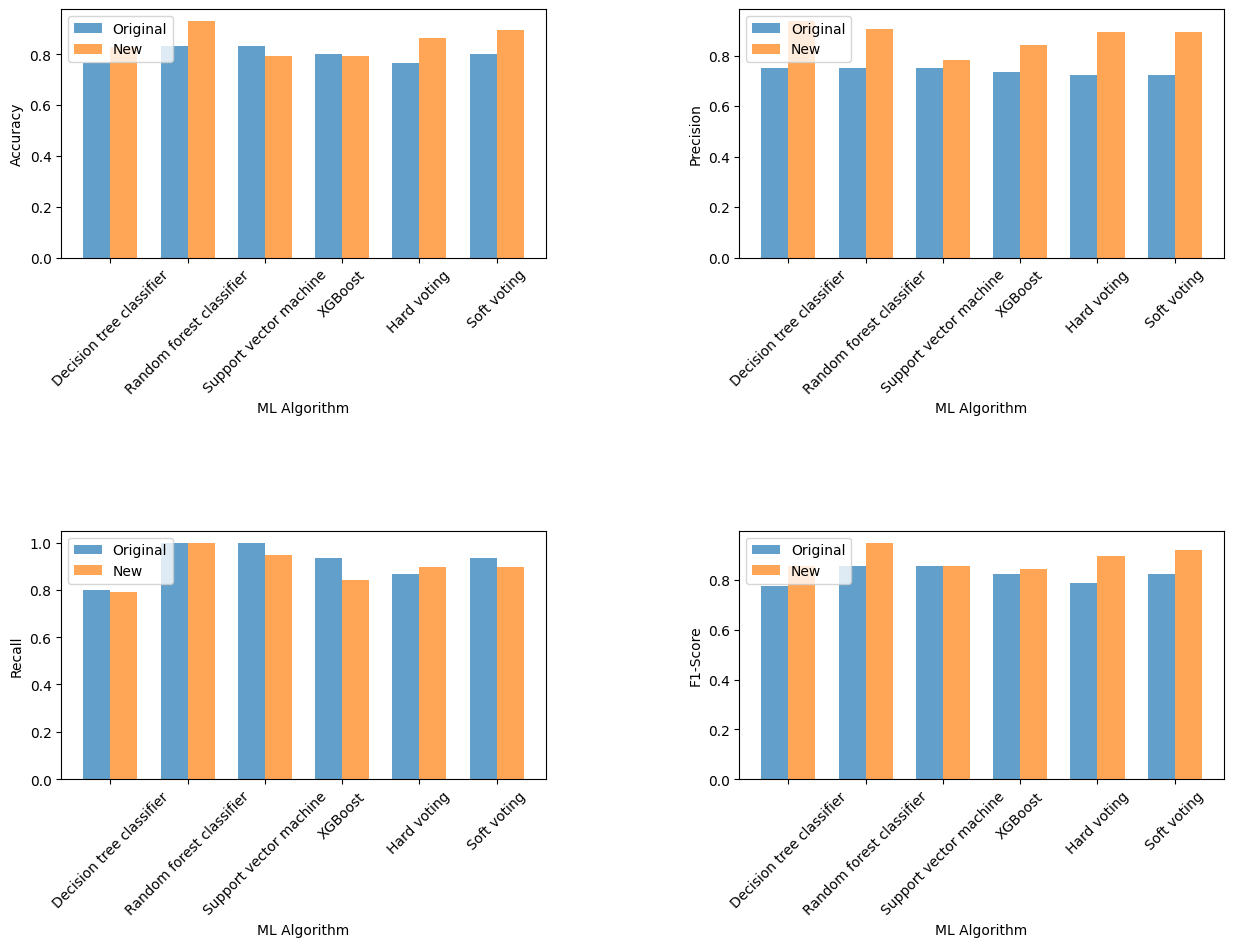

In [34]:
draw_comparison_bar_charts(accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig,
                           accuracies_drop, precisions_drop, recalls_drop, f1_scores_drop, models)

Uklanjanje nedostajućih vrijednosti, umjesto njihove zamjene medijanom, rezultiralo je vrlo sličnim rezultatima u usporedbi s izvornima. To je očekivano, s obzirom na to da je broj nedostajućih vrijednosti previše malen da bi ova promjena značajnije utjecala na ukupne rezultate.

### Povećanje skupa podataka

Sada ćemo pokušati povećati broj podataka u skupu kako bismo unaprijedili performanse. Možemo uzeti zadnji posjet pacijenata koji su kasnije konvertirani te ih klasificirati kao dementne.

Za ovu strategiju, potrebno je ponovno učitati i urediti cijeli podatkovni skup kako bismo osigurali konzistentnost i kvalitetu podataka prije nastavka analize.

In [35]:
alzheimer_original = pd.read_csv('/oasis_longitudinal.csv')
alzheimer_original = alzheimer_original.drop(['CDR'], axis=1)

#Za nekonvertirane pacijente uzimamo samo prvi posjet
non_converted = alzheimer_original[(alzheimer_original["Group"] != "Converted") & (alzheimer_original["Visit"] == 1)]

#za konvertirane uzimamo samo zadnji posjet jer znamo da su u zadnjem posjetu sigurno dementni
converted_lastVisit = (
    alzheimer_original[alzheimer_original["Group"] == "Converted"]
    .sort_values(by=["MRI ID", "Visit"])
    .groupby("MRI ID")
    .last()
    .reset_index()
)
converted_lastVisit.loc[converted_lastVisit['Group'] == 'Converted', 'Group'] = 'Demented'
alzheimer_original = pd.concat([non_converted, converted_lastVisit], ignore_index=True)
alzheimer_original = alzheimer_original.drop(['MR Delay'], axis=1)

mono_columns = ['Visit', 'MRI ID', 'Subject ID', 'Hand']

alzheimer_original.drop(mono_columns, axis=1, inplace=True)

missing_values = alzheimer_original.isnull().sum()

# Ispis značajki i broja nedostajućih vrijednosti
for column, value in missing_values.items():
    if value > 0:
        print(f"{column}: {value}")

# SES - izračun postotka nedostajućih vrijednosti
missing_value_percentage = (missing_values['SES'] / len(alzheimer_original)) * 100
print(f"Postotak nedostajućih vrijednosti za SES: {missing_value_percentage:.2f}%")

# Zamjena nedostajućih vrijednosti medianom
for column in alzheimer_original.columns:
    if alzheimer_original[column].isnull().sum() > 0:
        median_value = alzheimer_original[column].median()
        alzheimer_original[column].fillna(median_value, inplace=True)
        print(f"Nedostajuće vrijednosti u '{column}' zamijenjene medianom: {median_value}")


# Ponovna provjera nedostajućih vrijednosti
if alzheimer_original.isnull().sum().any():
    print("Nedostajuće vrijednosti i dalje postoje")
else:
    print("Nedostajuće vrijednosti više ne postoje")
categorical_columns = alzheimer_original.select_dtypes(include=[np.object_]).columns
numerical_columns = alzheimer_original.select_dtypes(include=[np.number]).columns

alzheimer_original = transform_data(alzheimer_original)
print(alzheimer_original.head(5))

SES: 8
Postotak nedostajućih vrijednosti za SES: 4.62%
Nedostajuće vrijednosti u 'SES' zamijenjene medianom: 2.0
Nedostajuće vrijednosti više ne postoje
{0: 'F', 1: 'M'}
{0: 'Demented', 1: 'Nondemented'}
        Age      EDUC       SES      MMSE      eTIV      nWBV       ASF  \
0  1.398877 -0.239983 -0.322392 -0.230502  3.026795 -1.015497 -2.410462   
1 -0.160773 -0.943663 -0.322392 -1.642071  1.203247  0.073660 -1.193144   
2  1.528848  1.167376  0.577186  0.122390 -1.529123 -0.634292  1.779204   
3  0.489081 -0.943663  1.476765  0.122390  1.268163 -0.579834 -1.245421   
4 -0.680656  0.463696 -0.322392  0.122390 -0.691118  0.400407  0.651504   

   M/F_M  Group_Nondemented  
0      1                  1  
1      1                  0  
2      0                  1  
3      1                  1  
4      1                  0  


In [36]:
y = alzheimer_original['Group_Nondemented']
X = alzheimer_original.drop(['Group_Nondemented'], axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
accuracies_biggerr, precisions_biggger, recalls_biggger, f1_scores_biggger, predictions_biggger = try_models(X_train, X_test, y_train, y_test)

In [39]:
print("Rezultati članka:")
print_results_article(df_results_article)
print("\n")
print("Naši rezultati sa povećanjem skupa podataka:")
print_results(accuracies, precisions, recalls, f1_scores, models)
print("\n")

Rezultati članka:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifier |  80.46%  |    0.8    |  0.79  |   0.78   |
| Random forest classifier |  86.92%  |   0.85    |  0.81  |   0.8    |
|  Support vector machine  |  81.67%  |   0.77    |  0.7   |   0.79   |
|         XGBoost          |  85.92%  |   0.85    |  0.83  |   0.85   |
|       Hard voting        |  85.12%  |   0.83    |  0.83  |   0.85   |
|    Voting classifier     |  85.12%  |   0.83    |  0.83  |   0.85   |
+--------------------------+----------+-----------+--------+----------+


Naši rezultati sa povećanjem skupa podataka:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+

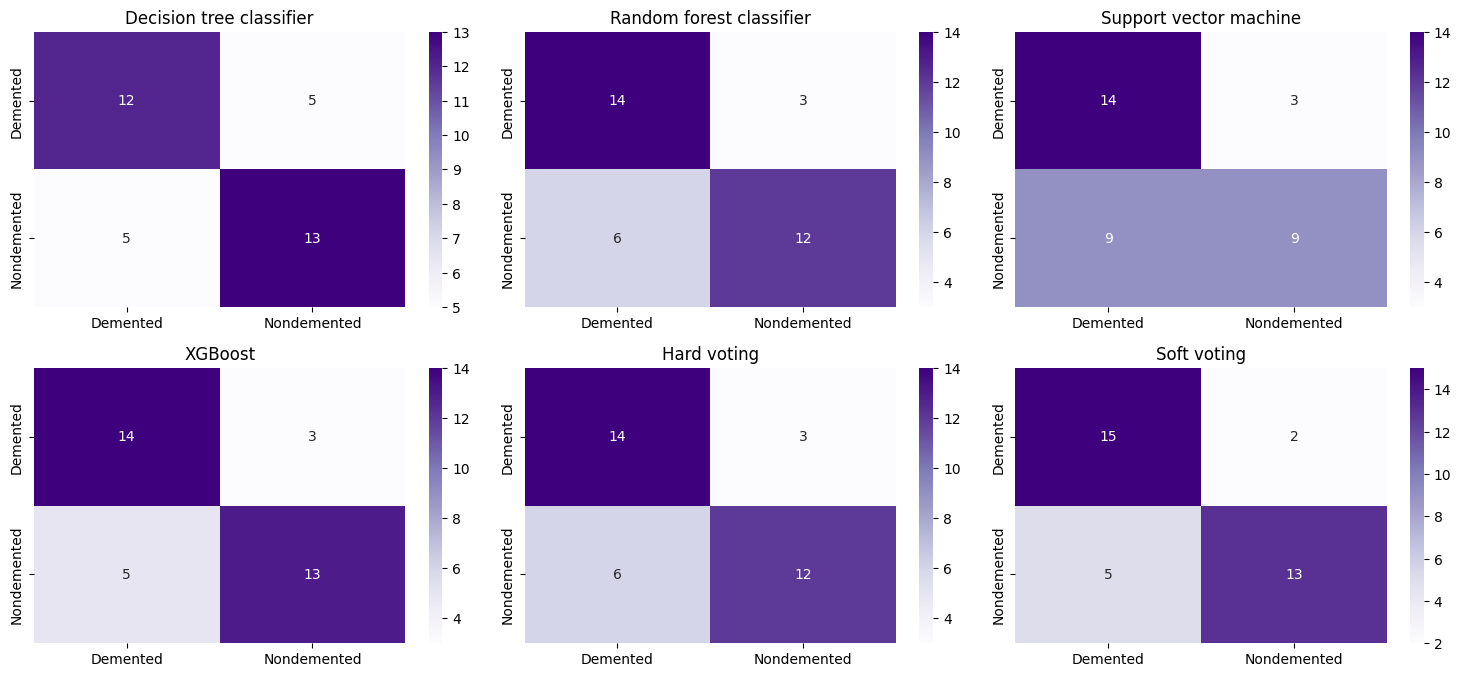

In [40]:
y_preds = [predictions_biggger[0], predictions_biggger[1], predictions_biggger[2], predictions_biggger[3], predictions_biggger[4], predictions_biggger[5]]
draw_confusion_matrices(y_test, y_preds)

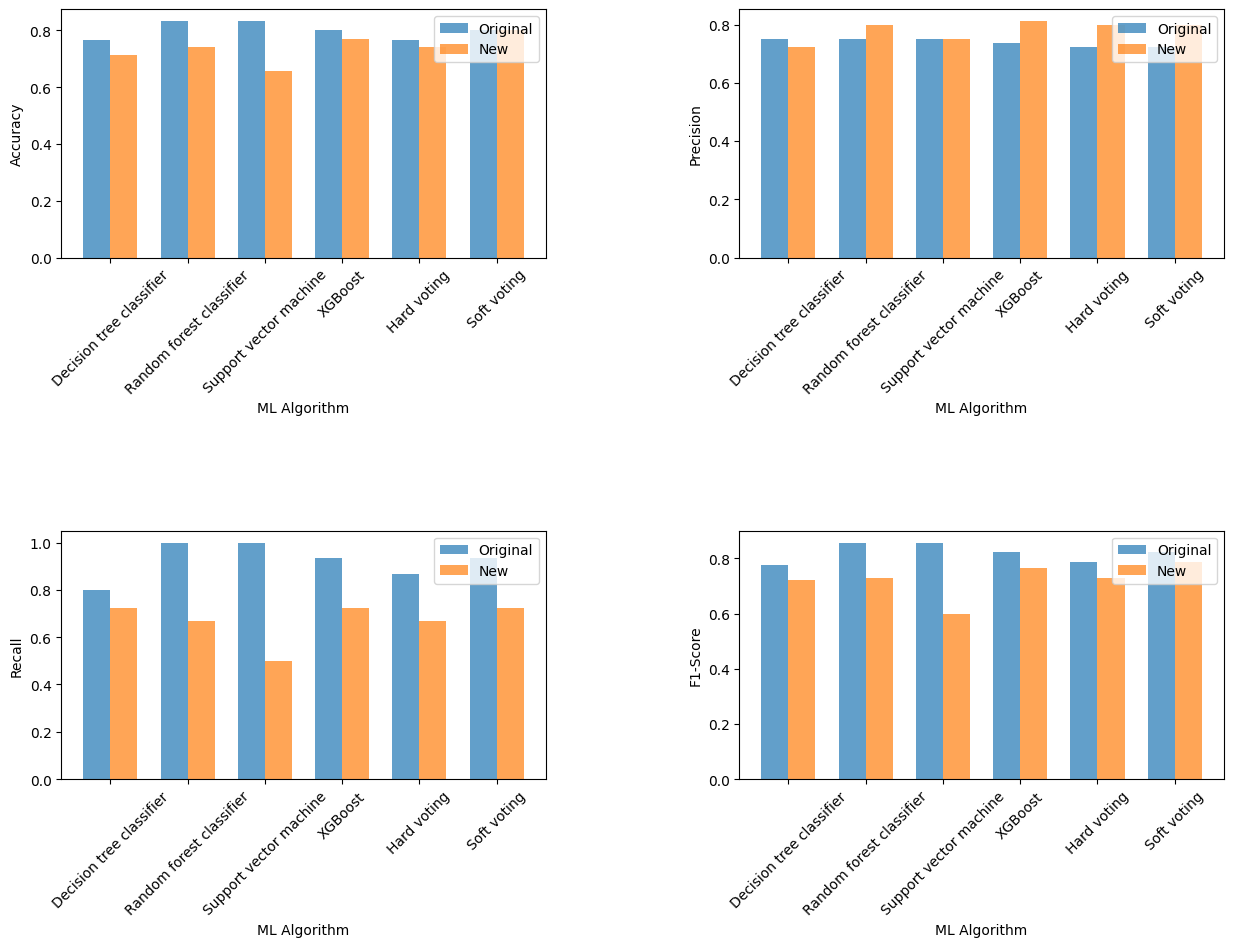

In [41]:
draw_comparison_bar_charts(accuracies_orig, precisions_orig, recalls_orig, f1_scores_orig,
                           accuracies_biggerr, precisions_biggger, recalls_biggger, f1_scores_biggger, models)

Ova metoda rezultirala je znatno lošijim performansama, što bi moglo biti posljedica činjenice da konvertirani pacijenti nisu bili u dovoljno dubokoj fazi demencije. Zbog toga su njihove mjere mogle odstupati od onih pravih dementnih pacijenata, što je potencijalno negativno utjecalo na učinkovitost modela.

### Biranje podskupa značajki

Možemo probati uzeti podskup značajki kako bismo izbjegli multikolinearnost značajki. Prvo ćemo analizirati matricu korelacije.

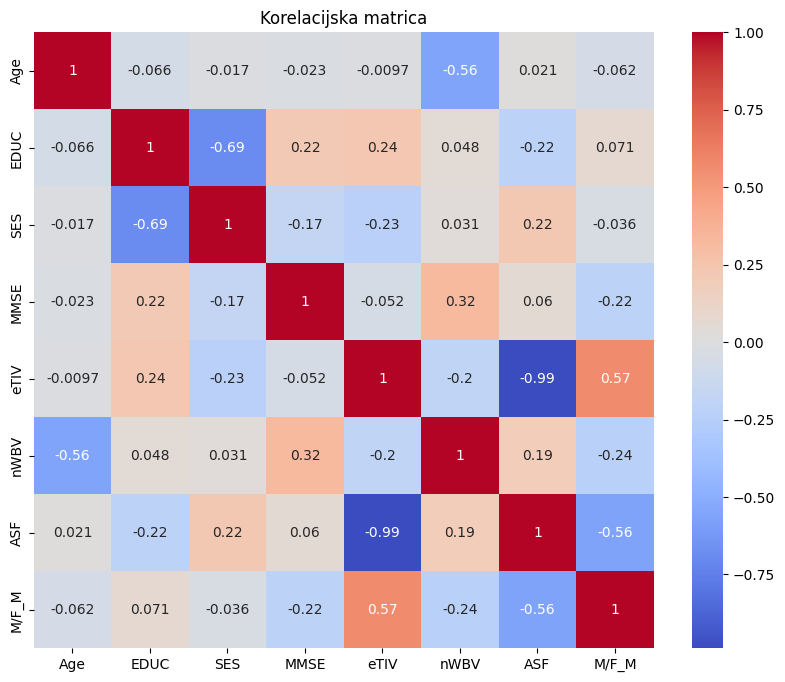

In [42]:
alzheimer_correlation_tmp = alzheimer_correlation.copy()

alzheimer_correlation_tmp = alzheimer_correlation_tmp.drop(['Group_Nondemented'], axis=1)
correlation_matrix = alzheimer_correlation_tmp.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True)
plt.title("Korelacijska matrica")
plt.show()

Vidimo veliku korelaciju između značajki `eTIV` i `ASF`. Izbacit ćemo značajku `eTIV`. Uz to možemo vidjeti i korlaciju između `SES` i `EDUC`, no ta korelacija nije toliko ekstremna.

In [43]:
alzheimer_correlation = alzheimer_correlation.drop(['eTIV'], axis=1)

In [44]:
y = alzheimer_correlation['Group_Nondemented']
X = alzheimer_correlation.drop(['Group_Nondemented'], axis=1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [46]:
accuracies_eTIV, precisions_eTIV, recalls_eTIV, f1_scores_eTIV, predictions_eTIV = try_models(X_train, X_test, y_train, y_test)

In [47]:
print("Rezultati članka:")
print_results_article(df_results_article)
print("\n")

print("Rezultati bez eTIV:")
print_results(accuracies_eTIV, precisions_eTIV, recalls_eTIV, f1_scores_eTIV, models)
print("\n")

Rezultati članka:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifier |  80.46%  |    0.8    |  0.79  |   0.78   |
| Random forest classifier |  86.92%  |   0.85    |  0.81  |   0.8    |
|  Support vector machine  |  81.67%  |   0.77    |  0.7   |   0.79   |
|         XGBoost          |  85.92%  |   0.85    |  0.83  |   0.85   |
|       Hard voting        |  85.12%  |   0.83    |  0.83  |   0.85   |
|    Voting classifier     |  85.12%  |   0.83    |  0.83  |   0.85   |
+--------------------------+----------+-----------+--------+----------+


Rezultati bez eTIV:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifi

Sad možemo probati i maknuti EDUC

In [48]:
alzheimer_correlation = alzheimer_correlation.drop(['EDUC'], axis=1)

In [49]:
X = alzheimer_correlation.drop(['Group_Nondemented'], axis=1)
y = alzheimer_correlation['Group_Nondemented']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
accuracies_EDUC, precisions_EDUC, recalls_EDUC, f1_scores_EDUC, predictions_EDUC = try_models(X_train, X_test, y_train, y_test)

In [52]:
print("Rezultati članka:")
print_results_article(df_results_article)
print("\n")

print("Rezultati bez EDUC:")
print_results(accuracies_EDUC, precisions_EDUC, recalls_EDUC, f1_scores_EDUC, models)
print("\n")

Rezultati članka:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifier |  80.46%  |    0.8    |  0.79  |   0.78   |
| Random forest classifier |  86.92%  |   0.85    |  0.81  |   0.8    |
|  Support vector machine  |  81.67%  |   0.77    |  0.7   |   0.79   |
|         XGBoost          |  85.92%  |   0.85    |  0.83  |   0.85   |
|       Hard voting        |  85.12%  |   0.83    |  0.83  |   0.85   |
|    Voting classifier     |  85.12%  |   0.83    |  0.83  |   0.85   |
+--------------------------+----------+-----------+--------+----------+


Rezultati bez EDUC:
+--------------------------+----------+-----------+--------+----------+
|          Model           | Accuracy | Precision | Recall | F1-score |
+--------------------------+----------+-----------+--------+----------+
| Decision tree classifi

Uklanjanje značajke eTIV pokazalo se kao dobar potez, dok je uklanjanje značajke EDUC bila loša odluka. Čini se da EDUC nije dovoljno snažno korelirana sa SES, a njeno uklanjanje rezultiralo je gubitkom značajne količine korisnih informacija i zato modeli imaju lošije performanse.